In [1]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, get_scorer_names, balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, make_scorer, precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [2]:
def calculate_gmean(accuracies):
    # Calcula o produto das taxas de acerto
    product = np.prod(accuracies)

    # Calcula a raiz quadrada do produto
    gmean = np.sqrt(product)

    return gmean

In [4]:
def avalia_indices(y_test, y_test_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    ac = (tp+tn)/(tp+tn+fp+fn)
    gms = []
    precision = tp/(tp+fp)
    sens = tp/(tp+fn)
    f1 = (2*precision*sens)/(precision+sens)
    esp = tn/(tn+fp)
    gms.append(sens)
    gms.append(esp)
    tfn = fn/(tp+fn)
    tfp = fp/(tn+fp)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    matt = matthews_corrcoef(y_test, y_test_pred)
    ef = (sens+esp)/2
    gmean = calculate_gmean(gms)
    # auc = roc_auc_score(y_test,y_test_pred)
    # matt = matthews_corrcoef(y_test,y_test_pred)
    # cohen = cohen_kappa_score(y_test,y_test_pred)
    print(f'Acurácia: {ac*100:.2f}%')
    print(f'Precisão: {precision*100:.2f}%')
    print(f'Recall: {sens*100:.2f}%')
    print(f'F1-Score: {f1*100:.2f}%')
    print(f'Especificidade: {esp*100:.2f}')
    print(f'TFN: {tfn*100:.2f}%')
    print(f'TFP: {tfp*100:.2f}%')
    print(f'ROC_AUC: {roc_auc*100:.2f}%')
    print(f'matt: {matt*100:.2f}%')
    print(f'Eficiência: {ef*100:.2f}%')
    print(f'Gmean: {gmean*100:.2f}%')
    # print(f'Área abaixo da curva ROC: {auc:.2f}')
    # print(f'Coeficiente de Matthews: {matt:.2f}')
    # print(f'Coeficiente de correlação de Kappa: {cohen:.2f}')

    scores = [ac, precision, sens, f1, esp, tfn, tfp, roc_auc, matt, ef, gmean]
    labels = ['Acurácia', '  Prec', 'Recall', 'F1','Esp','TFN', 'TFP','ROC', 'Matt', 'Efi', 'GMean']
    plt.bar(labels, scores, width=.2)
    plt.title('Avaliação dos índices de avaliação')
    plt.xlabel('Medidas de Avaliação')
    plt.grid(True, which='both', linestyle='--', linewidth=0.8, color='red')

In [5]:
d = {0:1,
     1:-1}
df = pd.read_csv('creditcard.csv')
df['Class'] = df['Class'].map(d)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,1
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,1
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,1
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,1


In [6]:
y = df['Class'].values
X= df.iloc[:, :30].values
X[:]
y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [7]:
X_train_val, X_test, y_train_val, y_test = \
    train_test_split(X, y, test_size=0.5, shuffle = True, random_state=27, stratify = y)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train_val, y_train_val, test_size=0.5, shuffle = True, random_state=27, stratify = y_train_val)
# print((np.bincount(y_train)))

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
scaler.fit(X_val)
X_val_std = scaler.transform(X_val)
scaler.fit(X_test)
X_test_std = scaler.transform(X_test)

print(np.shape(X_test))
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(y_test))
print(np.shape(y_train))
print(np.shape(y_val))

(142404, 30)
(71201, 30)
(71202, 30)
(142404,)
(71201,)
(71202,)


In [7]:
search_space = {
    'n_estimators': Integer((50), (1500)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': Integer(2,100),
    'min_samples_leaf':Integer(2,100),
    'max_features':['sqrt', 'log2', None],
    'max_leaf_nodes':Integer(2,100),
    # 'min_impurity_decrease': Real(0,1),
    # 'ccp_alpha':Real(0,1),
    'bootstrap': [True, False],
    'warm_start': [True, False]
}

In [8]:
model = ExtraTreesClassifier(class_weight='balanced')

In [9]:
clf = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=20,
    cv=10,
    n_jobs=-1,
    scoring='balanced_accuracy'
)
clf.fit(X_val_std,y=y_val)

BayesSearchCV(cv=10, estimator=ExtraTreesClassifier(class_weight='balanced'),
              n_iter=20, n_jobs=-1, scoring='balanced_accuracy',
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_features': ['sqrt', 'log2', None],
                             'max_leaf_nodes': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=1500, prior='uniform', transform='normalize'),
                             'warm_start': [True, False]})

In [10]:
print(clf.best_score_)
print(clf.best_params_)

0.932874807800254
OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_features', None), ('max_leaf_nodes', 100), ('min_samples_leaf', 100), ('min_samples_split', 26), ('n_estimators', 459), ('warm_start', False)])


In [11]:
params = dict(clf.best_params_)
bootstrap = params['bootstrap']
criterion = params['criterion']
max_features = params['max_features']
max_leaf_nodes = params['max_leaf_nodes']
min_samples_leaf = params['min_samples_leaf']
min_samples_split = params['min_samples_split']
n_estimators = params['n_estimators']
warm_start = params['warm_start']
print(params)

{'bootstrap': False, 'criterion': 'gini', 'max_features': None, 'max_leaf_nodes': 100, 'min_samples_leaf': 100, 'min_samples_split': 26, 'n_estimators': 459, 'warm_start': False}


In [9]:
# params = dict(clf.best_params_)
bootstrap = False
criterion = 'gini'
max_features = None
max_leaf_nodes = 100
min_samples_leaf = 100
min_samples_split = 26
n_estimators = 459
warm_start = False
# print(params)

In [10]:
train = ExtraTreesClassifier(class_weight='balanced', bootstrap = bootstrap, criterion=criterion, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators, warm_start=warm_start, random_state=87)
model = train.fit(X_train_std, y_train)

In [11]:
class MeuModelo:
    def __init__(self, bootstrap, criterion, max_features, max_leaf_nodes, min_samples_leaf, min_samples_split, n_estimators, warm_start):
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.n_estimators = n_estimators
        self.warm_start = warm_start
        self.modelo = ExtraTreesClassifier(class_weight='balanced', bootstrap = bootstrap, criterion=criterion, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators, warm_start=warm_start)

    def treinar(self, X_train, y_train):
        self.modelo.fit(X_train, y_train)

    def avaliar(self, X_test, y_test):
        y_test_pred = self.modelo.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_test_pred)
        # fig, ax = plt.subplots(figsize=(4, 4))
        # ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.9)
        # for i in range(conf_matrix.shape[0]):
        #     for j in range(conf_matrix.shape[1]):
        #         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
        # plt.xlabel('Predictions', fontsize=10)
        # plt.ylabel('Actuals', fontsize=10)
        # plt.title('Confusion Matrix', fontsize=10)
        # plt.show()
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        ac = (tp+tn)/(tp+tn+fp+fn)
        gms = []
        precision = tp/(tp+fp)
        sens = tp/(tp+fn)
        f1 = (2*precision*sens)/(precision+sens)
        esp = tn/(tn+fp)
        gms.append(sens)
        gms.append(esp)
        tfn = fn/(tp+fn)
        tfp = fp/(tn+fp)
        roc_auc = roc_auc_score(y_test, y_test_pred)
        matt = matthews_corrcoef(y_test, y_test_pred)
        ef = (sens+esp)/2
        gmean = calculate_gmean(gms)
        return ac, precision, sens, f1, esp, tfn, tfp, roc_auc, matt, ef, gmean

In [12]:
y_train_pred = model.predict(X_train_std)

In [13]:
y_val_pred = model.predict(X_val_std)

In [14]:
y_test_pred = model.predict(X_test_std)

In [17]:
print(f'Balance Acurracy tr: {balanced_accuracy_score(y_train, y_train_pred)}')

Balance Acurracy tr: 0.9986986127915811


In [18]:
print(f'Balance Acurracy val: {balanced_accuracy_score(y_val, y_val_pred)}')

Balance Acurracy val: 0.929494458072931


In [19]:
print(f'Balance Acurracy test: {balanced_accuracy_score(y_test, y_test_pred)}')

Balance Acurracy test: 0.9275885574244254


In [15]:
conf_matrix = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
conf_matrix

array([[  123,     0],
       [  153, 70925]], dtype=int64)

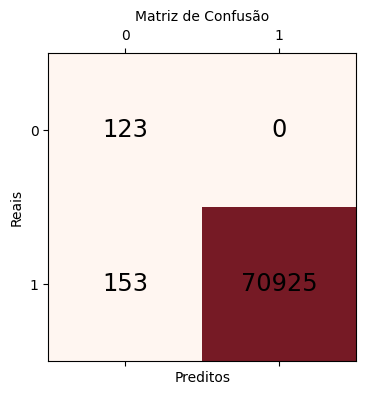

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.9)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Preditos', fontsize=10)
plt.ylabel('Reais', fontsize=10)
plt.title('Matriz de Confusão', fontsize=10)
plt.show()

Acurácia: 99.79%
Precisão: 100.00%
Recall: 99.78%
F1-Score: 99.89%
Especificidade: 100.00
TFN: 0.22%
TFP: 0.00%
ROC_AUC: 99.89%
matt: 66.69%
Eficiência: 99.89%
Gmean: 99.89%


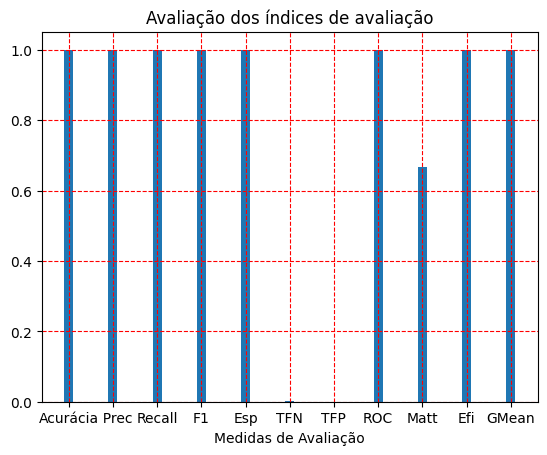

In [17]:
avalia_indices(y_train, y_train_pred)

In [18]:
print(roc_auc_score(y_train,y_train_pred))
print(cohen_kappa_score(y_train,y_train_pred))
print(matthews_corrcoef(y_train,y_train_pred))

0.9989237176060103
0.6156227185461445
0.6668529663544969


In [19]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
conf_matrix

array([[  106,    17],
       [  170, 70909]], dtype=int64)

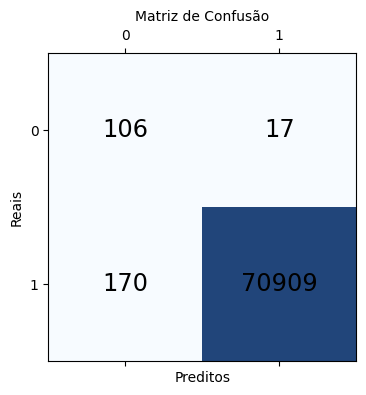

In [20]:
#here
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.9)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Preditos', fontsize=10)
plt.ylabel('Reais', fontsize=10)
plt.title('Matriz de Confusão', fontsize=10)
plt.show()

Acurácia: 99.74%
Precisão: 99.98%
Recall: 99.76%
F1-Score: 99.87%
Especificidade: 86.18
TFN: 0.24%
TFP: 13.82%
ROC_AUC: 92.97%
matt: 57.43%
Eficiência: 92.97%
Gmean: 92.72%


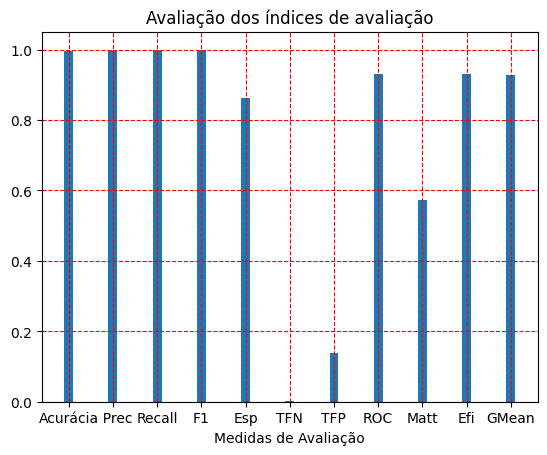

In [21]:
avalia_indices(y_val, y_val_pred)

In [22]:
print(roc_auc_score(y_val,y_val_pred))
print(cohen_kappa_score(y_val,y_val_pred))
print(matthews_corrcoef(y_val,y_val_pred))

0.929698456440944
0.53020556069639
0.5743276494095632


In [23]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
conf_matrix

array([[   211,     35],
       [   308, 141850]], dtype=int64)

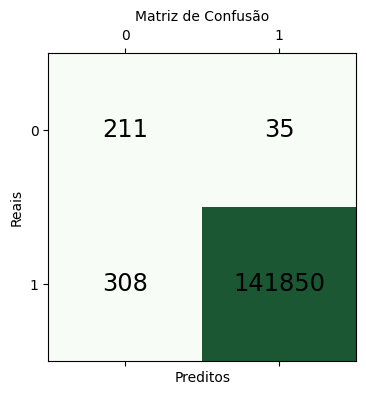

In [24]:
#here
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.9)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Preditos', fontsize=10)
plt.ylabel('Reais', fontsize=10)
plt.title('Matriz de Confusão', fontsize=10)
plt.show()

Acurácia: 99.76%
Precisão: 99.98%
Recall: 99.78%
F1-Score: 99.88%
Especificidade: 85.77
TFN: 0.22%
TFP: 14.23%
ROC_AUC: 92.78%
matt: 58.96%
Eficiência: 92.78%
Gmean: 92.51%


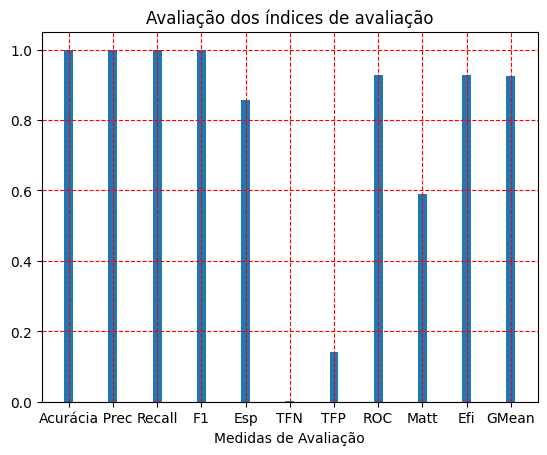

In [25]:
avalia_indices(y_test, y_test_pred)

In [25]:
print(roc_auc_score(y_test,y_test_pred))
print(cohen_kappa_score(y_test,y_test_pred))
print(matthews_corrcoef(y_test,y_test_pred))

0.9276940738216736
0.5337456106543337
0.5763482927361363


In [26]:
num_folds = 10

kf = KFold(n_splits=num_folds)

avaliacoes_ac = []
avaliacoes_precision = []
avaliacoes_sens = []
avaliacoes_f1 = []
avaliacoes_esp = []
avaliacoes_tfn = []
avaliacoes_tfp = []
avaliacoes_roc = []
avaliacoes_matt = []
avaliacoes_ef = []
avaliacoes_gmean = []

# return ac, precision, sens, f1, esp, tfn, tfp, roc_auc, matt, ef, gmean

X_kfold = X_test_std.copy()

for train_index, test_index in kf.split(X_kfold):
    X_tr, X_t = X_kfold[train_index], X_kfold[test_index]
    y_tr, y_t = y_test[train_index], y_test[test_index]

    modelo = MeuModelo(bootstrap = bootstrap, criterion=criterion, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators, warm_start=warm_start)

    modelo.treinar(X_tr, y_tr)

    ac, precision, sens, f1, esp, tfn, tfp, roc_auc, matt, ef, gm = modelo.avaliar(X_t, y_t)

    avaliacoes_ac.append(ac)
    avaliacoes_precision.append(precision)
    avaliacoes_sens.append(sens)
    avaliacoes_f1.append(f1)
    avaliacoes_esp.append(esp)
    avaliacoes_tfn.append(tfn)
    avaliacoes_tfp.append(tfp)
    avaliacoes_roc.append(roc_auc)
    avaliacoes_matt.append(matt)
    avaliacoes_ef.append(ef)
    avaliacoes_gmean.append(gm)
    

In [27]:
media_ac = np.mean(avaliacoes_ac)
media_precision = np.mean(avaliacoes_precision)
media_sens = np.mean(avaliacoes_sens)
media_f1 = np.mean(avaliacoes_f1)
media_esp = np.mean(avaliacoes_esp)
media_tfn = np.mean(avaliacoes_tfn)
media_tfp = np.mean(avaliacoes_tfp)
media_roc = np.mean(avaliacoes_roc)
media_matt = np.mean(avaliacoes_matt)
media_ef = np.mean(avaliacoes_ef)
media_gm = np.mean(avaliacoes_gmean)
std_ac = np.std(avaliacoes_ac)
std_precision = np.std(avaliacoes_precision)
std_sens = np.std(avaliacoes_sens)
std_f1 = np.std(avaliacoes_f1)
std_esp = np.std(avaliacoes_esp)
std_tfn = np.std(avaliacoes_tfn)
std_tfp = np.std(avaliacoes_tfp)
std_roc = np.std(avaliacoes_roc)
std_matt = np.std(avaliacoes_matt)
std_ef = np.std(avaliacoes_ef)
std_gm = np.std(avaliacoes_gmean)
avaliacoes_ef

[0.9034257584890497,
 0.9363042484349722,
 0.9430382713445358,
 0.9664752219018864,
 0.9156462585034013,
 0.9062113193190375,
 0.9758308929781712,
 0.9188744284206823,
 0.9460323687356356,
 0.9127375830767327]

In [28]:
print(f'Acurácia       - Media : {media_ac*100:.2f}%\t  Desvio Padrão: {std_ac*100:.2f}%')
print(f'Precisão       - Media : {media_precision*100:.2f}%\t  Desvio Padrão: {std_precision*100:.2f}%')
print(f'Recall         - Media : {media_sens*100:.2f}%\t  Desvio Padrão: {std_sens*100:.2f}%')
print(f'F1-Score       - Media : {media_f1*100:.2f}%\t  Desvio Padrão: {std_f1*100:.2f}%')
print(f'Especificidade - Media : {media_esp*100:.2f}%\t  Desvio Padrão: {std_esp*100:.2f}%')
print(f'TFN            - Media : {media_tfn*100:.2f}%\t  Desvio Padrão: {std_tfn*100:.2f}%')
print(f'TFP            - Media : {media_tfp*100:.2f}%\t  Desvio Padrão: {std_tfp*100:.2f}%')
print(f'ROC_AUC        - Media : {media_roc*100:.2f}%\t  Desvio Padrão: {std_roc*100:.2f}%')
print(f'Matt           - Media : {media_matt*100:.2f}%\t  Desvio Padrão: {std_matt*100:.2f}%')
print(f'Eficiência     - Media : {media_ef*100:.2f}%\t  Desvio Padrão: {std_ef*100:.2f}%')
print(f'Gmean          - Media : {media_gm*100:.2f}%\t  Desvio Padrão: {std_gm*100:.2f}%')

Acurácia       - Media : 99.73%	  Desvio Padrão: 0.02%
Precisão       - Media : 99.98%	  Desvio Padrão: 0.01%
Recall         - Media : 99.75%	  Desvio Padrão: 0.03%
F1-Score       - Media : 99.86%	  Desvio Padrão: 0.01%
Especificidade - Media : 86.74%	  Desvio Padrão: 4.81%
TFN            - Media : 0.25%	  Desvio Padrão: 0.03%
TFP            - Media : 13.26%	  Desvio Padrão: 4.81%
ROC_AUC        - Media : 93.25%	  Desvio Padrão: 2.40%
Matt           - Media : 56.83%	  Desvio Padrão: 4.59%
Eficiência     - Media : 93.25%	  Desvio Padrão: 2.40%
Gmean          - Media : 92.98%	  Desvio Padrão: 2.55%
